In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
# Deps
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.impute import SimpleImputer


## Load the data

In [3]:
# Load and preprocess the data
train_df = pd.read_csv(r'kaggle/input/optiver-trading-at-the-close/train.csv')
train_df.head()


,stock_id,date_id,seconds_in_bucket,imbalance_size,imbalance_buy_sell_flag,reference_price,matched_size,far_price,near_price,bid_price,bid_size,ask_price,ask_size,wap,target,time_id,row_id
0,0,0,0,3180602.69,1,0.999812,13380276.64,NaN,NaN,0.999812,60651.50,1.000026,8493.03,1.0,-3.029704,0,0_0_0
1,1,0,0,166603.91,-1,0.999896,1642214.25,NaN,NaN,0.999896,3233.04,1.000660,20605.09,1.0,-5.519986,0,0_0_1
2,2,0,0,302879.87,-1,0.999561,1819368.03,NaN,NaN,0.999403,37956.00,1.000298,18995.00,1.0,-8.389950,0,0_0_2
3,3,0,0,11917682.27,-1,1.000171,18389745.62,NaN,NaN,0.999999,2324.90,1.000214,479032.40,1.0,-4.010200,0,0_0_3
4,4,0,0,447549.96,-1,0.999532,17860614.95,NaN,NaN,0.999394,16485.54,1.000016,434.10,1.0,-7.349849,0,0_0_4


## EDA

In [4]:
def print_df(df):
    # Print the shape of the DataFrame
    print("Shape of the DataFrame:", df.shape)
    # Print the columns of the DataFrame
    print("Columns in the DataFrame:", df.columns)


print_df(train_df)

Shape of the DataFrame: (5237980, 17)
Columns in the DataFrame: Index(['stock_id', 'date_id', 'seconds_in_bucket', 'imbalance_size',
       'imbalance_buy_sell_flag', 'reference_price', 'matched_size',
       'far_price', 'near_price', 'bid_price', 'bid_size', 'ask_price',
       'ask_size', 'wap', 'target', 'time_id', 'row_id'],
      dtype='object')


In [5]:
# Available Stocks count
len(train_df.stock_id.unique())

200

<Axes: >

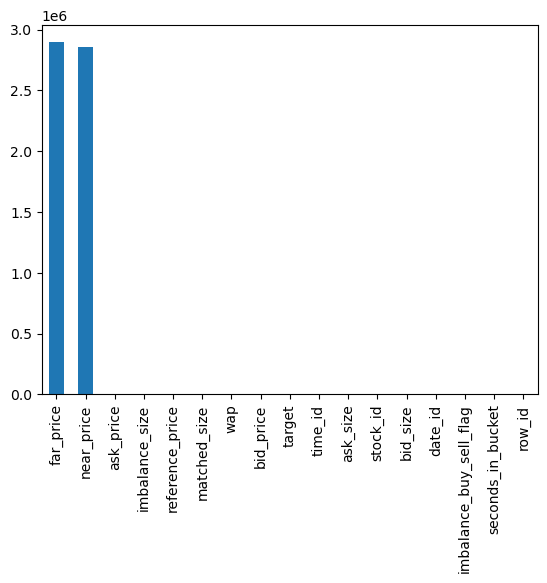

In [6]:
train_df.isna().sum().sort_values(ascending=False).plot(kind='bar')

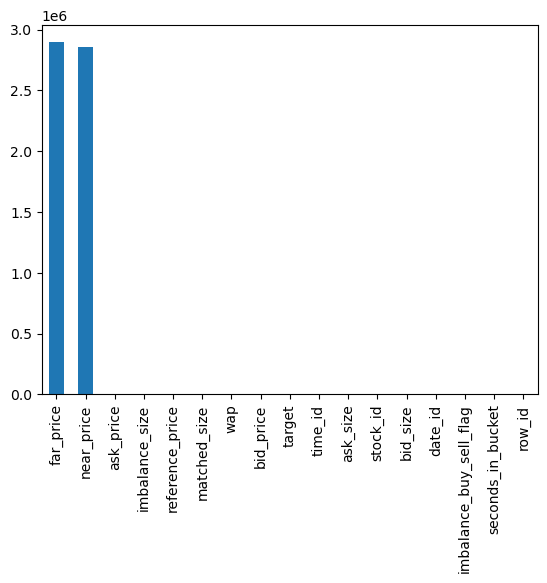

In [7]:
# Check the total null values of df
def check_null(df,return_null_cols=False, null_cols_count=2, ):
    df = df.copy()
    vals = df.isna().sum().sort_values(ascending=False).plot(kind='bar')
    if return_null_cols:
        return vals[:null_cols_count].index

null_cols = check_null(train_df)

In [8]:
null_cols

In [9]:
# Drip high null columsn
high_null_cols = train_df.isna().sum().sort_values(ascending=False)[:2].index

print(f"high null values: {high_null_cols}")

def drop_cols(df, cols):
    df = df.drop(cols, axis=1)
    return df

df = drop_cols(train_df, high_null_cols)
df = drop_cols(df, ['row_id'])

high null values: Index(['far_price', 'near_price'], dtype='object')


In [10]:
def imputer(df_processed):
    '''
    Function that receives a dataframe and returns the median value of each missing value in a column partitioned by stock_id,
    '''
    stock_list = list(df_processed['stock_id'].unique())

    imputer_columns = ['imbalance_size', 'reference_price', 'matched_size', 'bid_price', 'ask_price', 
                       'wap', 'target', 'seconds_in_bucket', 'bid_size', 'ask_size']

    # Create a single SimpleImputer instance for each column
    imputers = {col: SimpleImputer(missing_values=np.nan, strategy='median') for col in imputer_columns}

    for stock in stock_list:
        stock_df = df_processed.loc[df_processed['stock_id'] == stock]

        # Apply imputation to each column
        for col, imputer in imputers.items():
            stock_df.loc[:,col] = imputer.fit_transform(stock_df[col].values.reshape(-1,1))

        # Update the original DataFrame with imputed values
        df_processed.loc[df_processed['stock_id'] == stock, imputer_columns] = stock_df[imputer_columns].values

    return df_processed, imputers

df_processed, imputers = imputer(df)

In [11]:
imputers

{'imbalance_size': SimpleImputer(strategy='median'),
 'reference_price': SimpleImputer(strategy='median'),
 'matched_size': SimpleImputer(strategy='median'),
 'bid_price': SimpleImputer(strategy='median'),
 'ask_price': SimpleImputer(strategy='median'),
 'wap': SimpleImputer(strategy='median'),
 'target': SimpleImputer(strategy='median'),
 'seconds_in_bucket': SimpleImputer(strategy='median'),
 'bid_size': SimpleImputer(strategy='median'),
 'ask_size': SimpleImputer(strategy='median')}

In [12]:
def apply_imputer(df_processed, imputers):
    imputer_columns = ['imbalance_size', 'reference_price', 'matched_size', 'bid_price', 'ask_price',
                       'wap', 'seconds_in_bucket', 'bid_size', 'ask_size']

    for col in imputer_columns:
        df_processed[col] = imputers[col].transform(np.array(df_processed[col]).reshape(-1, 1))

    return df_processed

In [13]:
df_processed = apply_imputer(df_processed, imputers)

In [14]:
# ### Test dataset:
# test_df = pd.read_csv("kaggle/input/optiver-trading-at-the-close/example_test_files/test.csv")
# test_df_targets = pd.read_csv("kaggle/input/optiver-trading-at-the-close/example_test_files/revealed_targets.csv")

# sample_submission = pd.read_csv("kaggle/input/optiver-trading-at-the-close/example_test_files/sample_submission.csv")
# test_df


## PreProcessing for X Train y Train

In [29]:
df_processed["seconds_in_bucket"] = df_processed["seconds_in_bucket"].astype(np.int64)
df2 = df_processed.copy()
df2["seconds_in_bucket"] = df_processed["seconds_in_bucket"]+10
df_processed = pd.merge(
    df_processed,
    df2,
    how="inner",
    on=["date_id", "stock_id", "seconds_in_bucket"],
    suffixes=("", "_shift1")
    )
df_processed 

,stock_id,date_id,seconds_in_bucket,imbalance_size,imbalance_buy_sell_flag,reference_price,matched_size,bid_price,bid_size,ask_price,...,imbalance_buy_sell_flag_shift1,reference_price_shift1,matched_size_shift1,bid_price_shift1,bid_size_shift1,ask_price_shift1,ask_size_shift1,wap_shift1,target_shift1,time_id_shift1
0,0,0,10,1299772.70,1,1.000026,15261106.63,0.999812,13996.50,1.000026,...,1,0.999812,13380276.64,0.999812,60651.50,1.000026,8493.03,1.000000,-3.029704,0
1,1,0,10,165923.20,-1,0.999955,1642894.96,0.999896,3743.52,1.000660,...,-1,0.999896,1642214.25,0.999896,3233.04,1.000660,20605.09,1.000000,-5.519986,0
2,2,0,10,184766.21,-1,0.999561,1937481.68,0.999403,37956.00,1.000298,...,-1,0.999561,1819368.03,0.999403,37956.00,1.000298,18995.00,1.000000,-8.389950,0
3,3,0,10,10874033.58,-1,0.999870,19433394.31,0.999870,464.92,1.000042,...,-1,1.000171,18389745.62,0.999999,2324.90,1.000214,479032.40,1.000000,-4.010200,0
4,4,0,10,417742.24,-1,1.000154,17890422.68,1.000154,28799.28,1.000431,...,-1,0.999532,17860614.95,0.999394,16485.54,1.000016,434.10,1.000000,-7.349849,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5142739,195,480,540,2440722.89,-1,1.000317,28280361.74,1.000317,32257.04,1.000434,...,-1,1.000317,28280361.74,1.000317,68460.42,1.000434,123895.20,1.000359,4.019737,26453
5142740,196,480,540,349510.47,-1,1.000643,9187699.11,1.000643,205108.40,1.000900,...,-1,1.000643,9187699.11,1.000643,199192.56,1.000900,100127.96,1.000814,-7.349849,26453
5142741,197,480,540,0.00,0,0.995789,12725436.10,0.995789,16790.66,0.995883,...,-1,0.995976,12697368.89,0.995883,99371.80,0.996070,79937.60,0.995986,-3.259778,26453
5142742,198,480,540,1000898.84,1,0.999210,94773271.05,0.998970,125631.72,0.999210,...,1,0.999210,94773271.05,0.998970,143970.30,0.999210,447868.00,0.999028,-3.160238,26453


In [30]:
df_processed

,stock_id,date_id,seconds_in_bucket,imbalance_size,imbalance_buy_sell_flag,reference_price,matched_size,bid_price,bid_size,ask_price,...,imbalance_buy_sell_flag_shift1,reference_price_shift1,matched_size_shift1,bid_price_shift1,bid_size_shift1,ask_price_shift1,ask_size_shift1,wap_shift1,target_shift1,time_id_shift1
0,0,0,10,1299772.70,1,1.000026,15261106.63,0.999812,13996.50,1.000026,...,1,0.999812,13380276.64,0.999812,60651.50,1.000026,8493.03,1.000000,-3.029704,0
1,1,0,10,165923.20,-1,0.999955,1642894.96,0.999896,3743.52,1.000660,...,-1,0.999896,1642214.25,0.999896,3233.04,1.000660,20605.09,1.000000,-5.519986,0
2,2,0,10,184766.21,-1,0.999561,1937481.68,0.999403,37956.00,1.000298,...,-1,0.999561,1819368.03,0.999403,37956.00,1.000298,18995.00,1.000000,-8.389950,0
3,3,0,10,10874033.58,-1,0.999870,19433394.31,0.999870,464.92,1.000042,...,-1,1.000171,18389745.62,0.999999,2324.90,1.000214,479032.40,1.000000,-4.010200,0
4,4,0,10,417742.24,-1,1.000154,17890422.68,1.000154,28799.28,1.000431,...,-1,0.999532,17860614.95,0.999394,16485.54,1.000016,434.10,1.000000,-7.349849,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5142739,195,480,540,2440722.89,-1,1.000317,28280361.74,1.000317,32257.04,1.000434,...,-1,1.000317,28280361.74,1.000317,68460.42,1.000434,123895.20,1.000359,4.019737,26453
5142740,196,480,540,349510.47,-1,1.000643,9187699.11,1.000643,205108.40,1.000900,...,-1,1.000643,9187699.11,1.000643,199192.56,1.000900,100127.96,1.000814,-7.349849,26453
5142741,197,480,540,0.00,0,0.995789,12725436.10,0.995789,16790.66,0.995883,...,-1,0.995976,12697368.89,0.995883,99371.80,0.996070,79937.60,0.995986,-3.259778,26453
5142742,198,480,540,1000898.84,1,0.999210,94773271.05,0.998970,125631.72,0.999210,...,1,0.999210,94773271.05,0.998970,143970.30,0.999210,447868.00,0.999028,-3.160238,26453


In [31]:

y = df_processed['target']
X = df_processed.drop(['target'], axis = 1)

In [32]:
X = X.drop(['time_id'], axis = 1)


In [33]:
# Use this same cols to test data
X_cols = X.columns

In [34]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.8, random_state = 42)

## Building model

In [35]:
# Train the model
clf = xgb.XGBRegressor(n_estimators = 20, eval_metric = 'mae')


In [36]:
clf.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric='mae', feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=20, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [37]:
y_pred = clf.predict(X_test)
y_pred

array([ 0.17998567,  3.15803   , -4.3303175 , ..., -7.800147  ,
       -1.5176821 ,  5.6662474 ], dtype=float32)

## Evaluation

original mae 6.17

In [38]:
mae = mean_absolute_error(y_pred, y_test)
print("Mean Absolute Error: {}".format(mae))

Mean Absolute Error: 3.519103575736009


### Prediction on the real test data

In [25]:
test_preds = clf.predict(test_df[X_cols])
test_preds

NameError: name 'test_df' is not defined

In [ ]:
# pd.DataFrame({'row_id':sample_submission["row_id"],'target':test_preds}).to_csv('submission.csv', index=False)

In [ ]:
import optiver2023
env = optiver2023.make_env()
iter_test = env.iter_test()

In [ ]:
revealed = pd.read_csv('/kaggle/input/optiver-trading-at-the-close/example_test_files/revealed_targets.csv')
test = pd.read_csv('/kaggle/input/optiver-trading-at-the-close/example_test_files/test.csv')


In [ ]:
counter = 0
for (test, revealed_targets, test_preds) in iter_test:
    if counter == 0:
        print(test.head(3))
        print(revealed_targets.head(3))
        print(test_preds.head(3))
    test_preds['target'] = 0
    env.predict(test_preds)
    counter += 1